### Importing the required libraries

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import joblib
from keras.layers import LSTM, Dropout, Dense
from keras import Sequential
from math import sqrt
from matplotlib import pyplot
import tensorflow as tf
import keras.backend as K


### picked up a file to test

In [15]:
filename='SavedFilesBoth/55_1885.csv'

In [16]:
#reading the splitted datasets 
df= pd.read_csv(filename)

In [17]:
df.drop(columns=['meal_id','center_id'], inplace=True)
df.set_index(['week'],inplace=True)
df[['checkout_price', 'base_price', 'diff']]/=100

In [18]:
df.tail(15)

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,diff
week,,,,,,
131,1.4944,1.4944,0,0,162,0.00
132,1.5135,1.5235,0,0,162,0.01
133,1.4841,1.4841,0,0,122,0.00
134,1.5135,1.5035,0,0,82,-0.01
135,1.5041,1.4941,0,0,216,-0.01
136,1.4844,1.4844,0,0,134,0.00
137,1.5329,1.5429,0,0,96,0.01
138,1.5523,1.5623,0,0,81,0.01
139,1.5035,1.5235,0,0,67,0.02


In [19]:
df.describe(include='all')

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,diff
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,1.411890,1.458086,0.013793,0.062069,230.324138,0.046196
std,0.116722,0.088546,0.117036,0.242117,117.001418,0.108030
min,1.173700,1.164300,0.000000,0.000000,40.000000,-0.020000
25%,1.348600,1.435900,0.000000,0.000000,148.000000,0.000000
50%,1.445900,1.465000,0.000000,0.000000,215.000000,0.010000
75%,1.494100,1.503500,0.000000,0.000000,284.000000,0.020000
max,1.659300,1.659300,1.000000,1.000000,782.000000,0.446500


In [20]:
X= df.drop(columns=['num_orders']).values
Y= df.num_orders.values
X.reshape(-1,5)
Y.reshape(-1)

array([177, 323,  96, 163, 215, 285, 148, 135, 175, 175, 244, 190,  68,
       135, 366,  67, 270, 350, 244, 188, 136, 296, 188, 161,  55, 176,
       202, 296, 107, 135, 203, 123, 215, 231, 284, 161, 188, 175, 270,
       298, 323, 351, 378, 419, 256, 460, 350, 366, 433, 513, 284, 406,
       500, 404, 419, 323, 782, 284, 203, 271, 432, 108, 432, 231, 298,
       391, 420, 188, 391, 485, 351, 377, 175, 379, 404, 269, 257, 230,
       284, 271, 163, 148, 242, 216, 231, 204, 256, 377, 258, 271, 244,
       231, 176, 107, 257, 271, 203, 134, 109, 163, 242, 203, 406, 244,
       229, 230, 283, 149, 244, 161, 135,  68, 243, 148,  55,  69, 162,
       176, 123, 148,  94, 123, 217, 296, 109,  94, 231,  40,  94,  95,
       162, 162, 122,  82, 216, 134,  96,  81,  67, 204, 107, 121, 176,
       162, 121], dtype=int64)

### Trying multivariate Lstm model

In [106]:
input_data= df.drop(columns=['num_orders']).values

In [107]:
lookback= 3

test_size=int(.1 * len(df))
x=[]
y=[]
for i in range(len(df)-lookback):
    t=[]
    for j in range(0,lookback):
        
        t.append(input_data[[(i+j)], :])
    x.append(t)
    y.append(df.loc[:,'checkout_price':].values[i+ lookback,4])

In [108]:
x, y= np.array(x), np.array(y)
test_size= -1*(test_size+lookback)
x_test = x[test_size:]
y_test=y[test_size:]
y_train= y[:test_size]
x_train= x[:test_size]
x = x.reshape(x.shape[0],lookback, -1)
x_train = x_train.reshape(x_train.shape[0],lookback, -1)
x_test = x_test.reshape(x_test.shape[0],lookback, -1)
print(x.shape)
print(x_test.shape)
print(x_train.shape)

(142, 3, 5)
(17, 3, 5)
(125, 3, 5)


In [109]:
model = Sequential()
model.add(LSTM(units=5, return_sequences= True, input_shape=(x.shape[1],5)))
model.add(LSTM(units=10))
model.add(Dropout(0.5))
model.add(Dense(units=10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=5, activation='relu'))
model.add(Dense(units=1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 3, 5)              220       
_________________________________________________________________
lstm_11 (LSTM)               (None, 10)                640       
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [110]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [111]:
model.fit(x_train, y_train, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 0s 5ms/step - loss: 73612.3828 - accuracy: 0.0000e+00
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 73606.1953 - accuracy: 0.0000e+00
Epoch 3/1000
4/4 [==============================] - 0s 4ms/step - loss: 73600.3594 - accuracy: 0.0000e+00
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 73588.4688 - accuracy: 0.0000e+00
Epoch 5/1000
4/4 [==============================] - 0s 5ms/step - loss: 73583.6953 - accuracy: 0.0000e+00
Epoch 6/1000
4/4 [==============================] - 0s 4ms/step - loss: 73573.0234 - accuracy: 0.0000e+00
Epoch 7/1000
4/4 [==============================] - 0s 5ms/step - loss: 73551.9688 - accuracy: 0.0000e+00
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 73544.8047 - accuracy: 0.0000e+00
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 73540.2578 - accuracy: 0.0000e+00
Epoch 10/1000
4/4 [===========================

4/4 [==============================] - 0s 4ms/step - loss: 25125.2715 - accuracy: 0.0000e+00
Epoch 154/1000
4/4 [==============================] - 0s 4ms/step - loss: 22731.9668 - accuracy: 0.0000e+00
Epoch 155/1000
4/4 [==============================] - 0s 4ms/step - loss: 25284.2715 - accuracy: 0.0000e+00
Epoch 156/1000
4/4 [==============================] - 0s 4ms/step - loss: 26407.7109 - accuracy: 0.0000e+00
Epoch 157/1000
4/4 [==============================] - 0s 3ms/step - loss: 27653.0840 - accuracy: 0.0000e+00
Epoch 158/1000
4/4 [==============================] - 0s 4ms/step - loss: 22486.0156 - accuracy: 0.0000e+00
Epoch 159/1000
4/4 [==============================] - 0s 4ms/step - loss: 27186.9258 - accuracy: 0.0000e+00
Epoch 160/1000
4/4 [==============================] - 0s 4ms/step - loss: 26257.1992 - accuracy: 0.0000e+00
Epoch 161/1000
4/4 [==============================] - 0s 3ms/step - loss: 20161.8320 - accuracy: 0.0000e+00
Epoch 162/1000
4/4 [=======================

Epoch 304/1000
4/4 [==============================] - 0s 4ms/step - loss: 19782.7500 - accuracy: 0.0000e+00
Epoch 305/1000
4/4 [==============================] - 0s 4ms/step - loss: 26406.0781 - accuracy: 0.0000e+00
Epoch 306/1000
4/4 [==============================] - 0s 4ms/step - loss: 21340.0254 - accuracy: 0.0000e+00
Epoch 307/1000
4/4 [==============================] - 0s 4ms/step - loss: 19532.0684 - accuracy: 0.0000e+00
Epoch 308/1000
4/4 [==============================] - 0s 4ms/step - loss: 19861.1172 - accuracy: 0.0000e+00
Epoch 309/1000
4/4 [==============================] - 0s 4ms/step - loss: 23002.7266 - accuracy: 0.0000e+00
Epoch 310/1000
4/4 [==============================] - 0s 4ms/step - loss: 24401.7188 - accuracy: 0.0000e+00
Epoch 311/1000
4/4 [==============================] - 0s 4ms/step - loss: 24135.2930 - accuracy: 0.0000e+00
Epoch 312/1000
4/4 [==============================] - 0s 4ms/step - loss: 21419.9473 - accuracy: 0.0000e+00
Epoch 313/1000
4/4 [========

Epoch 455/1000
4/4 [==============================] - 0s 4ms/step - loss: 19887.0879 - accuracy: 0.0000e+00
Epoch 456/1000
4/4 [==============================] - 0s 5ms/step - loss: 21881.0039 - accuracy: 0.0000e+00
Epoch 457/1000
4/4 [==============================] - 0s 5ms/step - loss: 21419.6680 - accuracy: 0.0000e+00
Epoch 458/1000
4/4 [==============================] - 0s 4ms/step - loss: 22286.4141 - accuracy: 0.0000e+00
Epoch 459/1000
4/4 [==============================] - 0s 4ms/step - loss: 19698.2168 - accuracy: 0.0000e+00
Epoch 460/1000
4/4 [==============================] - 0s 4ms/step - loss: 20397.9082 - accuracy: 0.0000e+00
Epoch 461/1000
4/4 [==============================] - 0s 4ms/step - loss: 22697.7559 - accuracy: 0.0000e+00
Epoch 462/1000
4/4 [==============================] - 0s 4ms/step - loss: 23494.0527 - accuracy: 0.0000e+00
Epoch 463/1000
4/4 [==============================] - 0s 3ms/step - loss: 20125.4805 - accuracy: 0.0000e+00
Epoch 464/1000
4/4 [========

Epoch 606/1000
4/4 [==============================] - 0s 5ms/step - loss: 18923.1074 - accuracy: 0.0000e+00
Epoch 607/1000
4/4 [==============================] - 0s 5ms/step - loss: 18760.2363 - accuracy: 0.0000e+00
Epoch 608/1000
4/4 [==============================] - 0s 5ms/step - loss: 22767.3574 - accuracy: 0.0000e+00
Epoch 609/1000
4/4 [==============================] - 0s 4ms/step - loss: 18642.7363 - accuracy: 0.0000e+00
Epoch 610/1000
4/4 [==============================] - 0s 5ms/step - loss: 20283.0371 - accuracy: 0.0000e+00
Epoch 611/1000
4/4 [==============================] - 0s 5ms/step - loss: 21580.5527 - accuracy: 0.0000e+00
Epoch 612/1000
4/4 [==============================] - 0s 4ms/step - loss: 18723.4570 - accuracy: 0.0000e+00
Epoch 613/1000
4/4 [==============================] - 0s 4ms/step - loss: 19607.6484 - accuracy: 0.0000e+00
Epoch 614/1000
4/4 [==============================] - 0s 5ms/step - loss: 21203.7812 - accuracy: 0.0000e+00
Epoch 615/1000
4/4 [========

4/4 [==============================] - 0s 4ms/step - loss: 15711.2461 - accuracy: 0.0000e+00
Epoch 756/1000
4/4 [==============================] - 0s 4ms/step - loss: 19160.7305 - accuracy: 0.0000e+00
Epoch 757/1000
4/4 [==============================] - 0s 4ms/step - loss: 18604.6152 - accuracy: 0.0000e+00
Epoch 758/1000
4/4 [==============================] - 0s 4ms/step - loss: 17261.9883 - accuracy: 0.0000e+00
Epoch 759/1000
4/4 [==============================] - 0s 3ms/step - loss: 21303.5176 - accuracy: 0.0000e+00
Epoch 760/1000
4/4 [==============================] - 0s 3ms/step - loss: 16884.5957 - accuracy: 0.0000e+00
Epoch 761/1000
4/4 [==============================] - 0s 4ms/step - loss: 16507.4609 - accuracy: 0.0000e+00
Epoch 762/1000
4/4 [==============================] - 0s 3ms/step - loss: 15647.6533 - accuracy: 0.0000e+00
Epoch 763/1000
4/4 [==============================] - 0s 4ms/step - loss: 14870.4902 - accuracy: 0.0000e+00
Epoch 764/1000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 15154.8643 - accuracy: 0.0000e+00
Epoch 831/1000
4/4 [==============================] - 0s 4ms/step - loss: 17451.7383 - accuracy: 0.0000e+00
Epoch 832/1000
4/4 [==============================] - 0s 3ms/step - loss: 17676.9512 - accuracy: 0.0000e+00
Epoch 833/1000
4/4 [==============================] - 0s 3ms/step - loss: 15028.6562 - accuracy: 0.0000e+00
Epoch 834/1000
4/4 [==============================] - 0s 3ms/step - loss: 18851.8164 - accuracy: 0.0000e+00
Epoch 835/1000
4/4 [==============================] - 0s 3ms/step - loss: 17278.1113 - accuracy: 0.0000e+00
Epoch 836/1000
4/4 [==============================] - 0s 3ms/step - loss: 17251.1445 - accuracy: 0.0000e+00
Epoch 837/1000
4/4 [==============================] - 0s 4ms/step - loss: 16219.7520 - accuracy: 0.0000e+00
Epoch 838/1000
4/4 [==============================] - 0s 4ms/step - loss: 17697.2578 - accuracy: 0.0000e+00
Epoch 839/1000
4/4 [=======================

Epoch 906/1000
4/4 [==============================] - 0s 4ms/step - loss: 14365.8340 - accuracy: 0.0000e+00
Epoch 907/1000
4/4 [==============================] - 0s 4ms/step - loss: 15968.7969 - accuracy: 0.0000e+00
Epoch 908/1000
4/4 [==============================] - 0s 4ms/step - loss: 13872.4463 - accuracy: 0.0000e+00
Epoch 909/1000
4/4 [==============================] - 0s 3ms/step - loss: 17132.6875 - accuracy: 0.0000e+00
Epoch 910/1000
4/4 [==============================] - 0s 3ms/step - loss: 15177.7959 - accuracy: 0.0000e+00
Epoch 911/1000
4/4 [==============================] - 0s 3ms/step - loss: 17497.1934 - accuracy: 0.0000e+00
Epoch 912/1000
4/4 [==============================] - 0s 3ms/step - loss: 16687.5215 - accuracy: 0.0000e+00
Epoch 913/1000
4/4 [==============================] - 0s 4ms/step - loss: 18896.9297 - accuracy: 0.0000e+00
Epoch 914/1000
4/4 [==============================] - 0s 4ms/step - loss: 16911.0527 - accuracy: 0.0000e+00
Epoch 915/1000
4/4 [========

In [112]:
predicted_value= model.predict(x)
print(predicted_value.shape)
#print("training mse "+str(mse(y_train, model.predict(x_train))))
print("training mae "+str(mae(y_train, model.predict(x_train))))
#print("test mse "+str(mse(y_test, model.predict(x_test))))
print("test mae "+str(mae(y_test, model.predict(x_test))))

(142, 1)
training mae 84.56434008789063
test mae 75.14522687126609


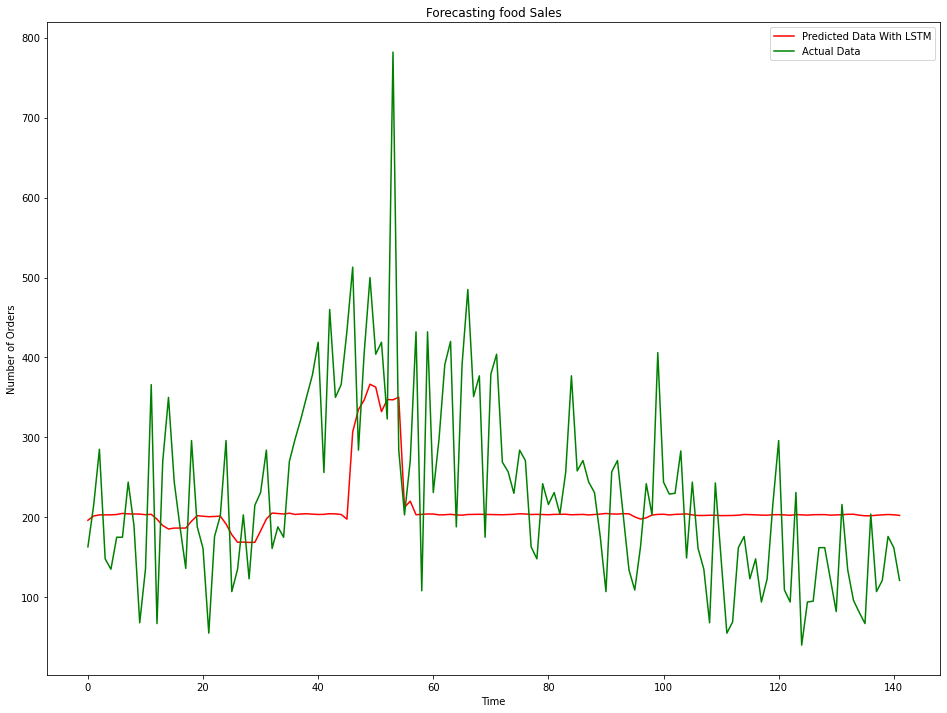

In [113]:
pyplot.figure(figsize=(16, 12))
pyplot.plot(predicted_value, color= 'red', label='Predicted Data With LSTM')
pyplot.plot(y, color='green', label='Actual Data')
pyplot.title("Forecasting food Sales")
pyplot.xlabel("Time")
pyplot.ylabel("Number of Orders")
pyplot.legend()
pyplot.show()

In [114]:
X_train, X_val, y_train, y_val= train_test_split( X, Y, test_size=0.15, random_state=101)

### Trying other simple ML algorithms

In [115]:
pipe1= Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=True)),
                 ('ext', RandomForestRegressor( random_state=101, max_depth=6, min_impurity_decrease=0.5))])

In [116]:
t=pipe1.fit(X_train, y_train )
pred1= pipe1.predict(X_val)
print(mae(y_train, pipe1.predict(X_train)))
mae(y_val, pred1)

45.68986178016662


90.1442155551339

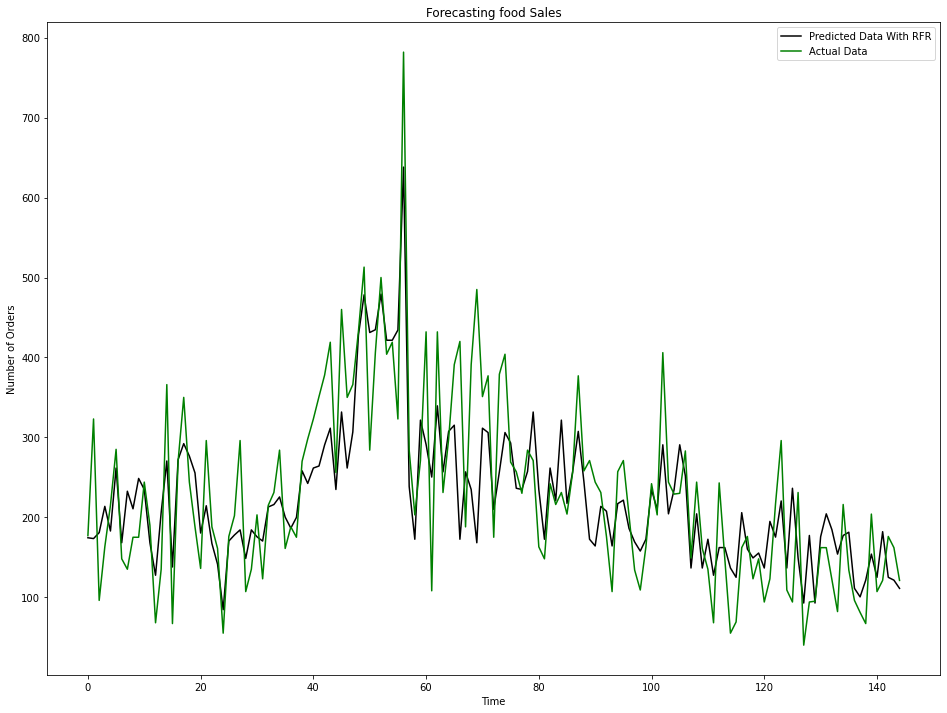

In [117]:
pyplot.figure(figsize=(16, 12))
pyplot.plot(pipe1.predict(X), color= 'black', label='Predicted Data With RFR')
pyplot.plot(Y, color='green', label='Actual Data')
pyplot.title("Forecasting food Sales")
pyplot.xlabel("Time")
pyplot.ylabel("Number of Orders")
pyplot.legend()
pyplot.show()

In [118]:
pipe2= Pipeline([('poly', PolynomialFeatures(degree=6, include_bias=True)),
                 ('lin', BayesianRidge(tol= 1e-8, n_iter=300, normalize=True))])


In [119]:
t=pipe2.fit(X_train, y_train)
pred2= pipe2.predict(X_val)
print(mae(y_train, pipe2.predict(X_train)))
mae(y_val, pred2)

72.50244003011879


100.27938530699522

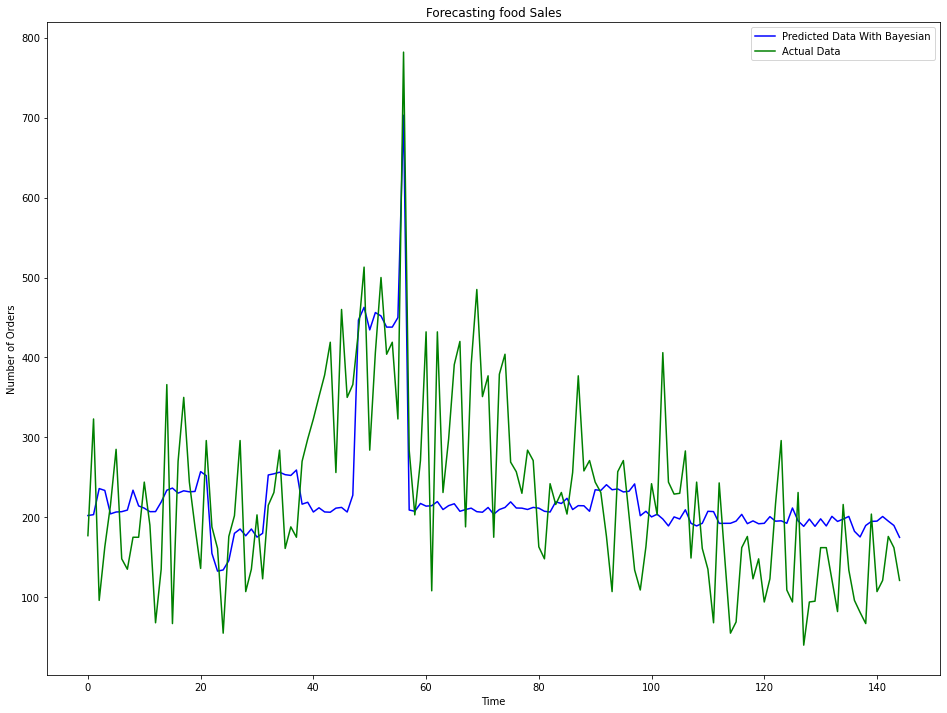

In [120]:
pyplot.figure(figsize=(16, 12))
pyplot.plot(pipe2.predict(X), color= 'blue', label='Predicted Data With Bayesian')
pyplot.plot(Y, color='green', label='Actual Data')
pyplot.title("Forecasting food Sales")
pyplot.xlabel("Time")
pyplot.ylabel("Number of Orders")
pyplot.legend()
pyplot.show()

In [121]:

pipe3= Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=True)),
                 ('KNN', KNeighborsRegressor(n_neighbors=100, weights='distance' ))])


In [122]:
t=pipe3.fit(X_train, y_train)
pred3= pipe3.predict(X_val)
print(mae(y_train, pipe3.predict(X_train)))
mae(y_val, pred3)

18.140677269309474


91.9048052946334

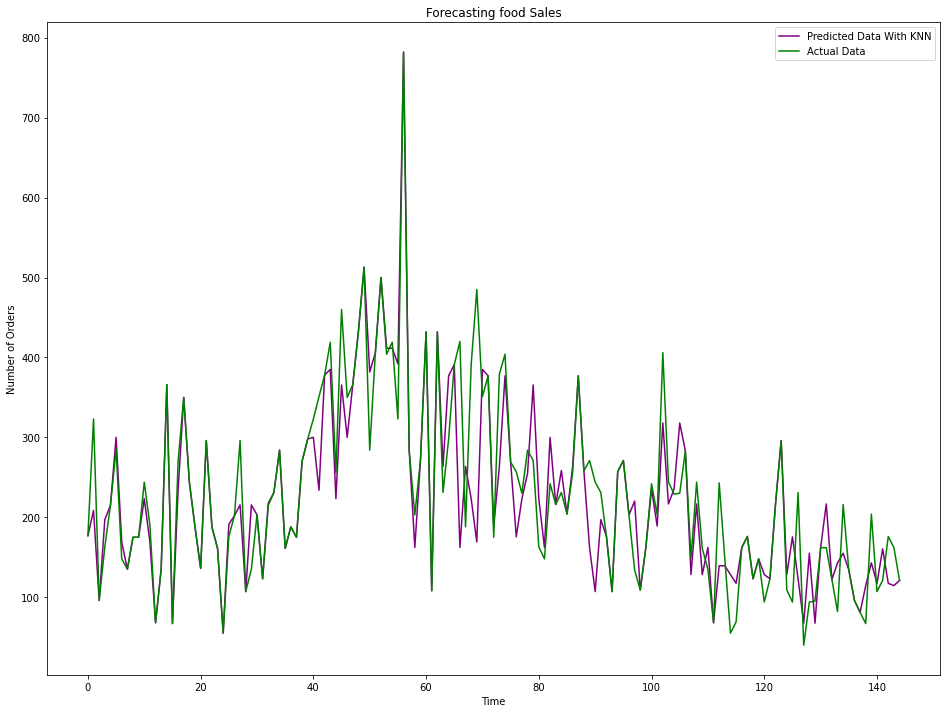

In [123]:
pyplot.figure(figsize=(16, 12))
pyplot.plot(pipe3.predict(X), color= 'purple', label='Predicted Data With KNN')
pyplot.plot(Y, color='green', label='Actual Data')
pyplot.title("Forecasting food Sales")
pyplot.xlabel("Time")
pyplot.ylabel("Number of Orders")
pyplot.legend()
pyplot.show()

In [124]:

pipe4= Pipeline([('poly', PolynomialFeatures(degree=3, include_bias=True)),
                 ('Hubber', HuberRegressor(epsilon=5.0, max_iter=800  ))])


In [125]:
t=pipe4.fit(X_train, y_train)
pred4= pipe4.predict(X_val)
print(mae(y_train, pipe4.predict(X_train)))
mae(y_val, pred4)

69.0049276078194


98.5483585555839

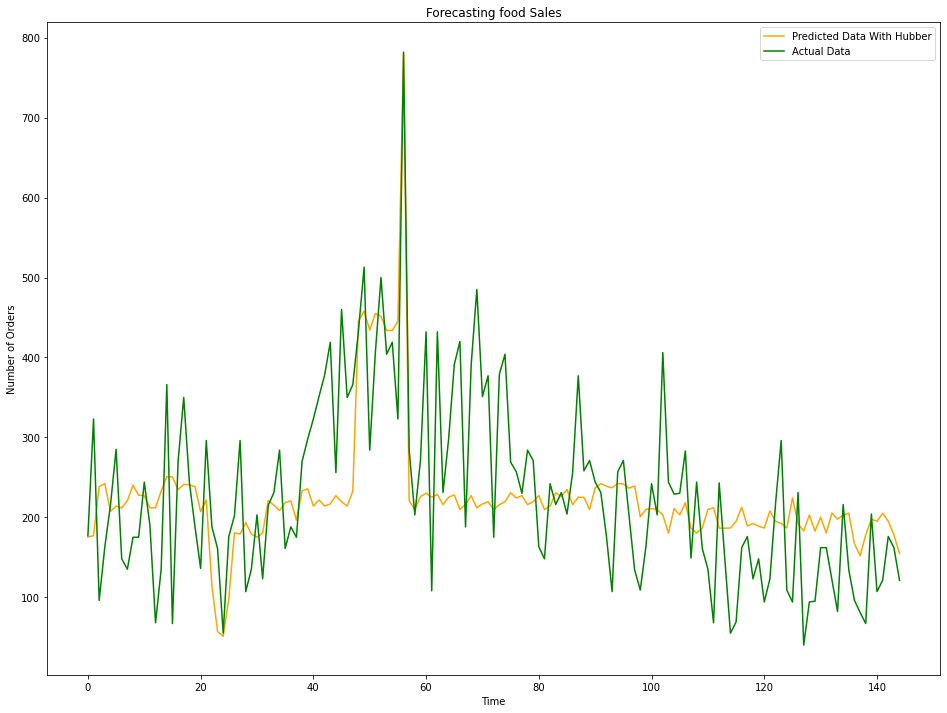

In [126]:
pyplot.figure(figsize=(16, 12))
pyplot.plot(pipe4.predict(X), color= 'orange', label='Predicted Data With Hubber')
pyplot.plot(Y, color='green', label='Actual Data')
pyplot.title("Forecasting food Sales")
pyplot.xlabel("Time")
pyplot.ylabel("Number of Orders")
pyplot.legend()
pyplot.show()

In [128]:
LSTm=[]
for i in range(lookback):
    LSTm.append(df['num_orders'].values[i])
for j in (predicted_value):
    LSTm.append(float(j))

len(LSTm)

145

In [129]:
df['RFR']= pipe1.predict(X)
df['BR']=pipe2.predict(X)
df['KNN']=pipe3.predict(X)
df['HR']=pipe4.predict(X)
df['LSTm']= LSTm

### Results of all the algorithms

In [130]:
df.head()

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,diff,RFR,BR,KNN,HR,LSTm
week,,,,,,,,,,,
1,1.3683,1.5229,0,0,177,0.1546,174.377613,202.174798,177.000000,175.402764,177.000000
2,1.3583,1.5229,0,0,323,0.1646,173.332644,203.287567,208.486540,177.007960,323.000000
3,1.3292,1.3392,0,0,96,0.0100,180.806135,235.896396,96.000000,238.501301,96.000000
4,1.3586,1.3486,0,0,163,-0.0100,213.666910,233.581231,197.000386,242.100492,196.254059
5,1.4650,1.4750,0,0,215,0.0100,182.825309,204.255727,214.999823,207.370070,201.623749


In [131]:
df.corr()

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,diff,RFR,BR,KNN,HR,LSTm
checkout_price,1.000000,0.473816,-0.192403,-0.368722,-0.231493,-0.692100,-0.362912,-0.479523,-0.285558,-0.434343,-0.176638
base_price,0.473816,1.000000,-0.010435,-0.011362,-0.149176,0.307708,-0.215964,-0.288502,-0.165802,-0.254324,0.018686
emailer_for_promotion,-0.192403,-0.010435,1.000000,0.459722,0.225856,0.199330,0.321713,0.383042,0.248716,0.351262,0.457546
homepage_featured,-0.368722,-0.011362,0.459722,1.000000,0.488102,0.389078,0.717886,0.911668,0.581186,0.859483,0.793603
num_orders,-0.231493,-0.149176,0.225856,0.488102,1.000000,0.127847,0.807249,0.578352,0.882975,0.610386,0.466015
diff,-0.692100,0.307708,0.199330,0.389078,0.127847,1.000000,0.215098,0.281637,0.172635,0.260835,0.206167
RFR,-0.362912,-0.215964,0.321713,0.717886,0.807249,0.215098,1.000000,0.787608,0.922830,0.816448,0.600432
BR,-0.479523,-0.288502,0.383042,0.911668,0.578352,0.281637,0.787608,1.000000,0.666858,0.973436,0.726263
KNN,-0.285558,-0.165802,0.248716,0.581186,0.882975,0.172635,0.922830,0.666858,1.000000,0.693767,0.519803
HR,-0.434343,-0.254324,0.351262,0.859483,0.610386,0.260835,0.816448,0.973436,0.693767,1.000000,0.693005


### Trying different combinations of ensembles

In [133]:
input_data= df.drop(columns=['num_orders','RFR', 'BR', 'HR', 'LSTm']).values
lookback= 2

test_size=int(.1 * len(df))
x=[]
y=[]
for i in range(len(df)-lookback):
    t=[]
    for j in range(0,lookback):
        
        t.append(input_data[[(i+j)], :])
    x.append(t)
    y.append(df.loc[:,'checkout_price':].values[i+ lookback,4])

In [146]:
X= df.drop(columns=['num_orders','KNN', 'BR', 'HR', 'LSTm']).values
Y= df.num_orders.values
X.reshape(-1,5)
Y.reshape(-1)

array([177, 323,  96, 163, 215, 285, 148, 135, 175, 175, 244, 190,  68,
       135, 366,  67, 270, 350, 244, 188, 136, 296, 188, 161,  55, 176,
       202, 296, 107, 135, 203, 123, 215, 231, 284, 161, 188, 175, 270,
       298, 323, 351, 378, 419, 256, 460, 350, 366, 433, 513, 284, 406,
       500, 404, 419, 323, 782, 284, 203, 271, 432, 108, 432, 231, 298,
       391, 420, 188, 391, 485, 351, 377, 175, 379, 404, 269, 257, 230,
       284, 271, 163, 148, 242, 216, 231, 204, 256, 377, 258, 271, 244,
       231, 176, 107, 257, 271, 203, 134, 109, 163, 242, 203, 406, 244,
       229, 230, 283, 149, 244, 161, 135,  68, 243, 148,  55,  69, 162,
       176, 123, 148,  94, 123, 217, 296, 109,  94, 231,  40,  94,  95,
       162, 162, 122,  82, 216, 134,  96,  81,  67, 204, 107, 121, 176,
       162, 121], dtype=int64)

In [147]:
x, y= np.array(x), np.array(y)
test_size= -1*(test_size+lookback)
x_test = x[test_size:]
y_test=y[test_size:]
y_train= y[:test_size]
x_train= x[:test_size]
x = x.reshape(x.shape[0],lookback, -1)
x_train = x_train.reshape(x_train.shape[0],lookback, -1)
x_test = x_test.reshape(x_test.shape[0],lookback, -1)
print(x.shape)
print(x_test.shape)
print(x_train.shape)

(143, 2, 6)
(16, 2, 6)
(127, 2, 6)


In [148]:
model = Sequential()
model.add(LSTM(units=5, return_sequences= True, input_shape=(x.shape[1],6)))
model.add(LSTM(units=10))
model.add(Dropout(0.5))
model.add(Dense(units=10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=5, activation='relu'))
model.add(Dense(units=1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 2, 5)              240       
_________________________________________________________________
lstm_17 (LSTM)               (None, 10)                640       
_________________________________________________________________
dropout_16 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_17 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                

In [149]:
X_train, X_val, y_train, y_val= train_test_split( X, Y, test_size=0.15, random_state=101)
pipe6=  Pipeline([('poly', PolynomialFeatures(degree=3, include_bias=True)),('Hubber', HuberRegressor(epsilon=5.0, max_iter=800  ))])
t=pipe6.fit(X_train, y_train)
pred6= pipe6.predict(X_val)
print(mae(y_train, pipe6.predict(X_train)))
mae(y_val, pred6)

41.63084686666245


103.35856710065914

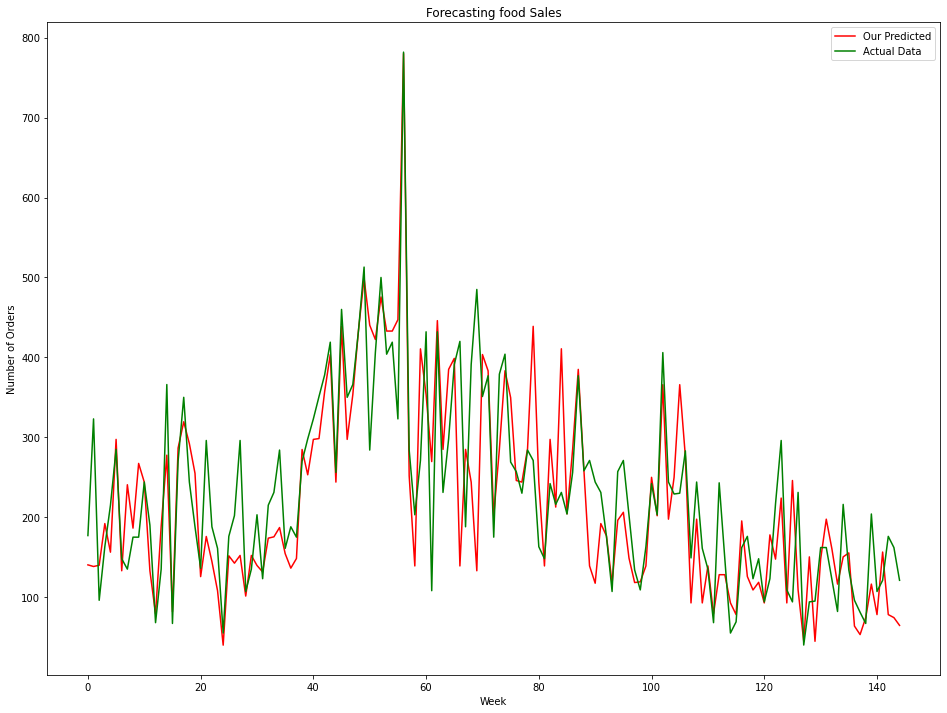

In [145]:
pyplot.figure(figsize=(16, 12))
pyplot.plot(pipe6.predict(X), color= 'Red', label='Our Predicted')
pyplot.plot(Y, color='green', label='Actual Data')
pyplot.title("Forecasting food Sales")
pyplot.xlabel("Week")
pyplot.ylabel("Number of Orders")
pyplot.legend()
pyplot.show()

In [150]:
df['y1']= pipe6.predict(X)

In [151]:
df.head()

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,diff,RFR,BR,KNN,HR,LSTm,y1
week,,,,,,,,,,,,
1,1.3683,1.5229,0,0,177,0.1546,174.377613,202.174798,177.000000,175.402764,177.000000,140.325859
2,1.3583,1.5229,0,0,323,0.1646,173.332644,203.287567,208.486540,177.007960,323.000000,138.286464
3,1.3292,1.3392,0,0,96,0.0100,180.806135,235.896396,96.000000,238.501301,96.000000,139.832325
4,1.3586,1.3486,0,0,163,-0.0100,213.666910,233.581231,197.000386,242.100492,196.254059,192.018526
5,1.4650,1.4750,0,0,215,0.0100,182.825309,204.255727,214.999823,207.370070,201.623749,156.213335


In [153]:
X= df.drop(columns=['num_orders','KNN', 'BR', 'HR', 'LSTm']).values
Y= df.num_orders.values
X.reshape(-1,7)
Y.reshape(-1)

array([177, 323,  96, 163, 215, 285, 148, 135, 175, 175, 244, 190,  68,
       135, 366,  67, 270, 350, 244, 188, 136, 296, 188, 161,  55, 176,
       202, 296, 107, 135, 203, 123, 215, 231, 284, 161, 188, 175, 270,
       298, 323, 351, 378, 419, 256, 460, 350, 366, 433, 513, 284, 406,
       500, 404, 419, 323, 782, 284, 203, 271, 432, 108, 432, 231, 298,
       391, 420, 188, 391, 485, 351, 377, 175, 379, 404, 269, 257, 230,
       284, 271, 163, 148, 242, 216, 231, 204, 256, 377, 258, 271, 244,
       231, 176, 107, 257, 271, 203, 134, 109, 163, 242, 203, 406, 244,
       229, 230, 283, 149, 244, 161, 135,  68, 243, 148,  55,  69, 162,
       176, 123, 148,  94, 123, 217, 296, 109,  94, 231,  40,  94,  95,
       162, 162, 122,  82, 216, 134,  96,  81,  67, 204, 107, 121, 176,
       162, 121], dtype=int64)

In [175]:
model= Sequential()
model.add(Dense(units=7, activation='relu', input_shape=(7,)))
model.add(Dropout(0.1))
model.add(Dense(units=14, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(units=7, activation='relu'))
model.add(Dense(units=1))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 7)                 56        
_________________________________________________________________
dropout_24 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 14)                112       
_________________________________________________________________
dropout_25 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 7)                 105       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 8         
Total params: 281
Trainable params: 281
Non-trainable params: 0
_______________________________________________________

In [176]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [177]:
X_train, X_val, y_train, y_val= train_test_split( X, Y, test_size=0.15, random_state=101)

In [178]:
model.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 0s 767us/step - loss: 21976.6172 - accuracy: 0.0000e+00
Epoch 2/1000
4/4 [==============================] - 0s 754us/step - loss: 18778.0781 - accuracy: 0.0000e+00
Epoch 3/1000
4/4 [==============================] - 0s 1ms/step - loss: 14167.6113 - accuracy: 0.0000e+00
Epoch 4/1000
4/4 [==============================] - 0s 1ms/step - loss: 17680.9453 - accuracy: 0.0000e+00
Epoch 5/1000
4/4 [==============================] - 0s 748us/step - loss: 11505.9834 - accuracy: 0.0000e+00
Epoch 6/1000
4/4 [==============================] - 0s 998us/step - loss: 11273.6221 - accuracy: 0.0000e+00
Epoch 7/1000
4/4 [==============================] - 0s 748us/step - loss: 10833.7168 - accuracy: 0.0000e+00
Epoch 8/1000
4/4 [==============================] - 0s 748us/step - loss: 10289.0381 - accuracy: 0.0000e+00
Epoch 9/1000
4/4 [==============================] - 0s 1ms/step - loss: 8633.9277 - accuracy: 0.0000e+00
Epoch 10/1000
4/4 [================

4/4 [==============================] - 0s 499us/step - loss: 3293.3386 - accuracy: 0.0000e+00
Epoch 153/1000
4/4 [==============================] - 0s 994us/step - loss: 3151.8074 - accuracy: 0.0000e+00
Epoch 154/1000
4/4 [==============================] - 0s 748us/step - loss: 3354.8481 - accuracy: 0.0000e+00
Epoch 155/1000
4/4 [==============================] - 0s 498us/step - loss: 4114.4863 - accuracy: 0.0000e+00
Epoch 156/1000
4/4 [==============================] - 0s 746us/step - loss: 3373.6311 - accuracy: 0.0000e+00
Epoch 157/1000
4/4 [==============================] - 0s 978us/step - loss: 3798.1987 - accuracy: 0.0000e+00
Epoch 158/1000
4/4 [==============================] - 0s 499us/step - loss: 3319.2249 - accuracy: 0.0000e+00
Epoch 159/1000
4/4 [==============================] - 0s 499us/step - loss: 3698.8982 - accuracy: 0.0000e+00
Epoch 160/1000
4/4 [==============================] - 0s 741us/step - loss: 3350.2571 - accuracy: 0.0000e+00
Epoch 161/1000
4/4 [==============

4/4 [==============================] - 0s 750us/step - loss: 3263.0234 - accuracy: 0.0000e+00
Epoch 303/1000
4/4 [==============================] - 0s 748us/step - loss: 3534.4053 - accuracy: 0.0000e+00
Epoch 304/1000
4/4 [==============================] - 0s 746us/step - loss: 3716.0432 - accuracy: 0.0000e+00
Epoch 305/1000
4/4 [==============================] - 0s 997us/step - loss: 2762.4553 - accuracy: 0.0000e+00
Epoch 306/1000
4/4 [==============================] - 0s 499us/step - loss: 3157.9229 - accuracy: 0.0000e+00
Epoch 307/1000
4/4 [==============================] - 0s 748us/step - loss: 2818.0608 - accuracy: 0.0000e+00
Epoch 308/1000
4/4 [==============================] - 0s 749us/step - loss: 3092.2476 - accuracy: 0.0000e+00
Epoch 309/1000
4/4 [==============================] - 0s 748us/step - loss: 2780.5693 - accuracy: 0.0000e+00
Epoch 310/1000
4/4 [==============================] - 0s 998us/step - loss: 3364.1467 - accuracy: 0.0000e+00
Epoch 311/1000
4/4 [==============

4/4 [==============================] - 0s 748us/step - loss: 2658.8125 - accuracy: 0.0000e+00
Epoch 453/1000
4/4 [==============================] - 0s 998us/step - loss: 3195.5818 - accuracy: 0.0000e+00
Epoch 454/1000
4/4 [==============================] - 0s 748us/step - loss: 2929.9502 - accuracy: 0.0000e+00
Epoch 455/1000
4/4 [==============================] - 0s 499us/step - loss: 2986.9119 - accuracy: 0.0000e+00
Epoch 456/1000
4/4 [==============================] - 0s 998us/step - loss: 2980.0789 - accuracy: 0.0000e+00
Epoch 457/1000
4/4 [==============================] - 0s 748us/step - loss: 2912.4570 - accuracy: 0.0000e+00
Epoch 458/1000
4/4 [==============================] - 0s 739us/step - loss: 2789.3645 - accuracy: 0.0000e+00
Epoch 459/1000
4/4 [==============================] - 0s 748us/step - loss: 2951.5071 - accuracy: 0.0000e+00
Epoch 460/1000
4/4 [==============================] - 0s 757us/step - loss: 2763.8147 - accuracy: 0.0000e+00
Epoch 461/1000
4/4 [==============

4/4 [==============================] - 0s 751us/step - loss: 2793.6804 - accuracy: 0.0000e+00
Epoch 603/1000
4/4 [==============================] - 0s 501us/step - loss: 3269.0396 - accuracy: 0.0000e+00
Epoch 604/1000
4/4 [==============================] - 0s 989us/step - loss: 4270.5493 - accuracy: 0.0000e+00
Epoch 605/1000
4/4 [==============================] - 0s 748us/step - loss: 3436.3501 - accuracy: 0.0000e+00
Epoch 606/1000
4/4 [==============================] - 0s 499us/step - loss: 2684.8582 - accuracy: 0.0000e+00
Epoch 607/1000
4/4 [==============================] - 0s 996us/step - loss: 3033.7336 - accuracy: 0.0000e+00
Epoch 608/1000
4/4 [==============================] - 0s 997us/step - loss: 2706.8328 - accuracy: 0.0000e+00
Epoch 609/1000
4/4 [==============================] - 0s 499us/step - loss: 2963.9260 - accuracy: 0.0000e+00
Epoch 610/1000
4/4 [==============================] - 0s 742us/step - loss: 3019.4363 - accuracy: 0.0000e+00
Epoch 611/1000
4/4 [==============

4/4 [==============================] - 0s 997us/step - loss: 2807.0042 - accuracy: 0.0000e+00
Epoch 753/1000
4/4 [==============================] - 0s 753us/step - loss: 3082.0940 - accuracy: 0.0000e+00
Epoch 754/1000
4/4 [==============================] - 0s 754us/step - loss: 3469.2578 - accuracy: 0.0000e+00
Epoch 755/1000
4/4 [==============================] - 0s 746us/step - loss: 2808.7053 - accuracy: 0.0000e+00
Epoch 756/1000
4/4 [==============================] - 0s 742us/step - loss: 2874.7163 - accuracy: 0.0000e+00
Epoch 757/1000
4/4 [==============================] - 0s 499us/step - loss: 3759.0371 - accuracy: 0.0000e+00
Epoch 758/1000
4/4 [==============================] - 0s 748us/step - loss: 2876.1543 - accuracy: 0.0000e+00
Epoch 759/1000
4/4 [==============================] - 0s 749us/step - loss: 3028.1133 - accuracy: 0.0000e+00
Epoch 760/1000
4/4 [==============================] - 0s 748us/step - loss: 2944.1165 - accuracy: 0.0000e+00
Epoch 761/1000
4/4 [==============

4/4 [==============================] - 0s 748us/step - loss: 2748.0791 - accuracy: 0.0000e+00
Epoch 903/1000
4/4 [==============================] - 0s 998us/step - loss: 3314.2961 - accuracy: 0.0000e+00
Epoch 904/1000
4/4 [==============================] - 0s 748us/step - loss: 2556.3848 - accuracy: 0.0000e+00
Epoch 905/1000
4/4 [==============================] - 0s 755us/step - loss: 2622.6936 - accuracy: 0.0000e+00
Epoch 906/1000
4/4 [==============================] - 0s 742us/step - loss: 2881.2922 - accuracy: 0.0000e+00
Epoch 907/1000
4/4 [==============================] - 0s 748us/step - loss: 2997.8018 - accuracy: 0.0000e+00
Epoch 908/1000
4/4 [==============================] - 0s 499us/step - loss: 3146.4998 - accuracy: 0.0000e+00
Epoch 909/1000
4/4 [==============================] - 0s 748us/step - loss: 3165.0715 - accuracy: 0.0000e+00
Epoch 910/1000
4/4 [==============================] - 0s 998us/step - loss: 2837.8357 - accuracy: 0.0000e+00
Epoch 911/1000
4/4 [==============

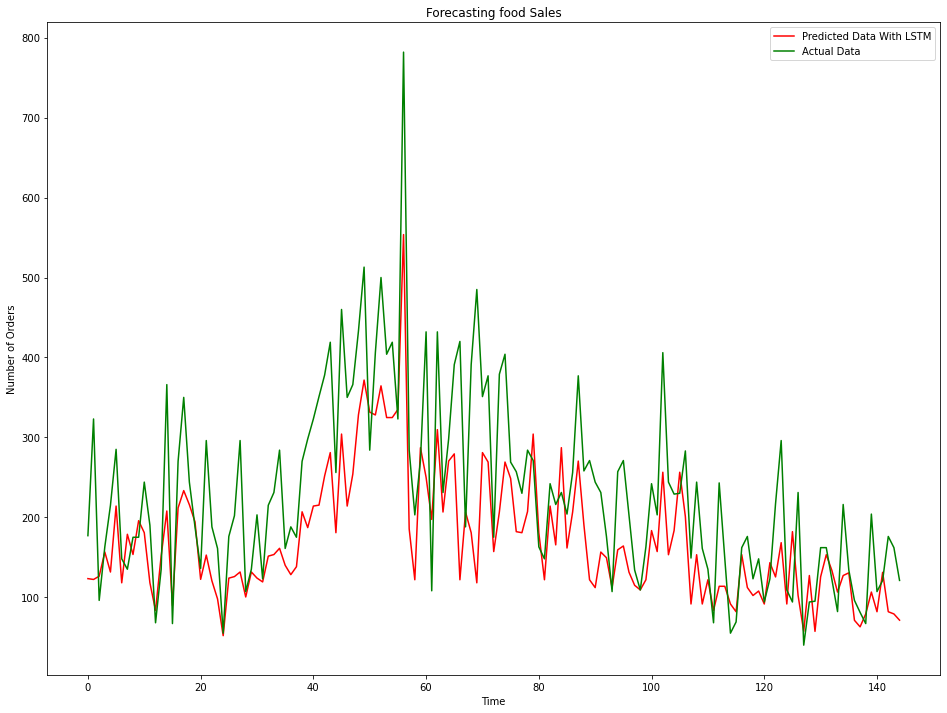

In [179]:
pyplot.figure(figsize=(16, 12))
pyplot.plot(model.predict(X), color= 'red', label='Final Predicted Data With LSTM')
pyplot.plot(Y, color='green', label='Actual Data')
pyplot.title("Forecasting food Sales")
pyplot.xlabel("Time")
pyplot.ylabel("Number of Orders")
pyplot.legend()

pyplot.show()

In [180]:
print(mae(y_val, model.predict(X_val)))
mae(y_train, model.predict(X_train))

108.21017456054688


62.600976959476625

In [185]:
model.save('model_save2.h5')

In [186]:
model1= Sequential()
model1.add(Dense(units=7, activation='relu', input_shape=(7,)))
model1.add(Dropout(0.1))
model1.add(Dense(units=14, activation='relu'))
model1.add(Dropout(0.15))
model1.add(Dense(units=7, activation='relu'))
model1.add(Dense(units=1))
model1.load_weights('model_save2.h5')

In [187]:
mae(y_val, model1.predict(X_val))

108.21017456054688